In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
import re
import nltk
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import Conv1D, GlobalMaxPooling1D,MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras import metrics
from keras import backend as K
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from keras.models import load_model
import tensorflow as tf
import requests
import nltk
from sklearn.preprocessing import StandardScaler
nltk.download('stopwords')
nltk.download('punkt')

stop_words = stopwords.words('english')
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
ext_stopwords = list(set(stopwords_list.decode().splitlines()))

stop_words.extend(ext_stopwords)

es = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=15,
                              verbose=1, mode='auto')
mc = ModelCheckpoint('/content/drive/MyDrive/covariance_final_project.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True, restore_best_weights=True)

GLOVE_6B_100D_PATH = "/content/drive/MyDrive/glove.6B.100d.txt"
encoding='utf-8'

#reading traing and test data

df = pd.read_csv('/content/drive/MyDrive/data_model.csv')
# df = df[df['language']=='en']



# df.loc[df['track_popularity']>=50,'popularity'] = 1
# df.loc[df['track_popularity']<50,'popularity'] = 0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
import nltk
nltk.download('stopwords')
# df.dropna()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# import os
# os.listdir()

In [12]:
def glove(total):
    """
    Glove word vector is read and vectors is given to each vector and dictionary
    is returned where all the words in corpus as key with their vector as value.
    Parameter:
        total(dict): dictionary containing all the words
    Return
        dictionary of words with their wordvectors
    """
    glove_small = {}
    all_words = set(w for words in total for w in words)
    with open(GLOVE_6B_100D_PATH, "rb") as infile:
        for line in infile:
            parts = line.split()
            word = parts[0].decode(encoding)
            if (word in all_words):
                nums=np.array(parts[1:], dtype=np.float32)
                glove_small[word] = nums
        infile.close()
    return glove_small

# from ftfy import fix_text
# def preprocessing(string, n=3):
#     string = fix_text(string) # fix text encoding issues
#     string = string.encode("ascii", errors="ignore").decode() #remove non ascii chars
#     string = string.lower() #make lower case
#     chars_to_remove = [")","(",".","|","[","]","{","}","'"]
#     rx = '[' + re.escape(''.join(chars_to_remove)) + ']'
#     string = re.sub(rx, '', string) #remove the list of chars defined above
#     string = string.replace('&', 'and')
#     string = string.replace(',', ' ')
#     string = string.replace('-', ' ')
#     string = string.title() # normalise case - capital at start of each word
#     string = re.sub(' +',' ',string).strip() # get rid of multiple spaces and replace with a single space
#     string = ' '+ string +' ' # pad names for ngrams...
#     string = re.sub(r'[,-./]|\sBD',r'', string)
#     ngrams = zip(*[string[i:] for i in range(n)])
#     return [''.join(ngram) for ngram in ngrams]

def preprocessing(text):
    """
    It takes the string and preprocess the string with the help pf nltk library
    Parameters:
        text(str): string which needs to be prerprocessed
    Return
        preprocessed string with no stopwords
    """
    # from nltk.corpus import stopwords
    text=str(text).lower()

    text=re.sub('[^a-z]+', ' ', text)
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    # remove stopwords
    # stop = stopwords.words('english')
    tokens = [token for token in tokens if token not in ext_stopwords]

    # remove words less than three letters
    tokens = [word for word in tokens if len(word) >= 3]

    # lower capitalization
    tokens = [word.lower() for word in tokens]

    # lemmatize
#    porter = PorterStemmer()
#    tokens = [porter.stem(word) for word in tokens]
    preprocessed_text= ' '.join(tokens)
    return preprocessed_text

class MeanEmbeddingVectorizer(object):

    """
    Class simply returns the vector of word

    """
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = 100

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([([self.word2vec[w] for w in words if w in self.word2vec])
            for words in X
        ])

def list_lists(filing):
    """
    Spliting the article in words
    Parameter:
        filing(series/list): contains all the filings having 10Q/K filings with mda extracted
    Return :
        List of lists of words
    """
    test=[]
    for i in filing:
        i=preprocessing(i)
        i=i.split()
        test.append(i)
    return test

def get_covariance_vector(article,w2v,n):
    """
    Get Covariance vectors which is calculated by transposing word vectors and calculating
    By numpy and taking upper triangular matrix as vector
    Parameter:
        article(list): list of lists of words
        w2v: object from Meanembeddingvectoriser
        n(int): number of articles
    Return
        numpy vector
    """
    covariance_vector=[]
    for i in article:
    #    i = train_article[4]
        word_vector = w2v.transform([i])
        word_vector = word_vector.reshape(word_vector.shape[1],100)
        word_vector_transpose = word_vector.transpose()
        covariance_matrix = np.cov(word_vector_transpose)
        covariance_matrix = covariance_matrix.astype(np.float16, copy=False)
        upper_tri_covar_matrix = covariance_matrix[np.triu_indices(100)]
        covariance_vector.append(upper_tri_covar_matrix)
    covariance_vector=np.array(covariance_vector,dtype='float16')
    covariance_vector=covariance_vector.reshape(n,5050,1)

    return covariance_vector

def check_model(model,x,y,x_test,y_test,es,mc):
    """
    Takes model and training set and test set and check the model by taking look on val_loss
    if it is decreasing or not
    """
    model.fit(x,y,batch_size=8,epochs=100,verbose=1,validation_data=(x_test, y_test),callbacks=[es,mc])

def build_regression_model():
    """
    Building model using deep neural network using keras for regression
    """
    model = Sequential()
    # model.add(Dense(2048, activation='relu', input_shape=(5092, 1)))
    model.add(Dense(1024, activation='relu', input_shape=(1006, 1)))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))  # Change to linear for regression
    model.summary()
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=10000, decay_rate=0.001)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='mean_squared_error',  # Change to mean squared error for regression
                  optimizer=optimizer)
    return model



In [7]:
# article = list_lists(X_train)
# article = list_lists(df['lyrics'])
# w2v_train = glove(article)
# w2v=MeanEmbeddingVectorizer(w2v_train).fit(article)
# X = get_covariance_vector(article,w2v,len(article))

# categorical_cols = ['playlist_genre', 'playlist_subgenre']
# temp_df = pd.get_dummies(df, columns=categorical_cols)

# arr2_reshaped = np.reshape(temp_df.iloc[:,23:].values, (15405, 30, 1))
# X = np.concatenate((X, arr2_reshaped), axis=1)

# # print (X.shape,'-----')

# reshaped = np.reshape(df.iloc[:,12:24].values, (15405, 12, 1))
# X = np.concatenate((X, reshaped), axis=1)

X = df.iloc[:,:-1].values
# # print (X.shape,'-----')
# scaler = StandardScaler()

X_2d = X.reshape(-1, X.shape[1])

scaler = StandardScaler()
scaled_data_2d = scaler.fit_transform(X_2d)
X = scaled_data_2d.reshape(len(df), X.shape[1], 1)
# scaler.fit(X_train)

In [8]:
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence',
       ...
       'rhymes_per_line_238', 'rhymes_per_line_239', 'rhymes_per_line_240',
       'rhymes_per_line_241', 'rhymes_per_line_242', 'rhymes_per_line_243',
       'rhymes_per_line_244', 'rhymes_per_line_245', 'rhymes_per_line_246',
       'rhymes_per_line_247'],
      dtype='object', length=1007)

In [9]:
X = np.nan_to_num(X, nan=0.0)
nan_count = np.isnan(X).sum()
print("Number of NaN values in the array:", nan_count)

Number of NaN values in the array: 0


In [10]:
X.shape


(15129, 1006, 1)

In [13]:
from sklearn.metrics import mean_squared_error
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, df['track_popularity'],test_size=0.2,train_size=0.8)

# m = build()
# check_model(m,X_train_scaled,y_train,X_test_scaled,y_test,es,mc)
# m = load_model('/content/drive/MyDrive/covariance_final_project.h5')
# y_score_test = m.predict(X_test_scaled)
# y_score_test = (y_score_test>0.50)
# report_test=classification_report(y_test,y_score_test)
# print (report_test)



In [14]:
# Build and compile the regression model
regression_model = build_regression_model()

# Replace 'check_model' with a function appropriate for regression
def train_regression_model(model, x, y, x_val, y_val, es, mc):
    model.fit(x, y, batch_size=8, epochs=100, verbose=1, validation_data=(x_val, y_val), callbacks=[es, mc])

# Train the model
train_regression_model(regression_model, X_train_scaled, y_train, X_test_scaled, y_test, es, mc)

# Load the best model saved by ModelCheckpoint
best_model = load_model('/content/drive/MyDrive/covariance_final_project.h5')

# Predict with the regression model
y_pred_test = best_model.predict(X_test_scaled)

# Calculate the mean squared error for the test set
mse_test = mean_squared_error(y_test, y_pred_test)
print("Test MSE:", mse_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1006, 1024)        2048      
                                                                 
 dense_1 (Dense)             (None, 1006, 512)         524800    
                                                                 
 dense_2 (Dense)             (None, 1006, 256)         131328    
                                                                 
 dense_3 (Dense)             (None, 1006, 128)         32896     
                                                                 
 dense_4 (Dense)             (None, 1006, 64)          8256      
                                                                 
 dense_5 (Dense)             (None, 1006, 32)          2080      
                                                                 
 dense_6 (Dense)             (None, 1006, 8)           2

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Test MaE:", mae_test)

Test MaE: 21.1444300435186


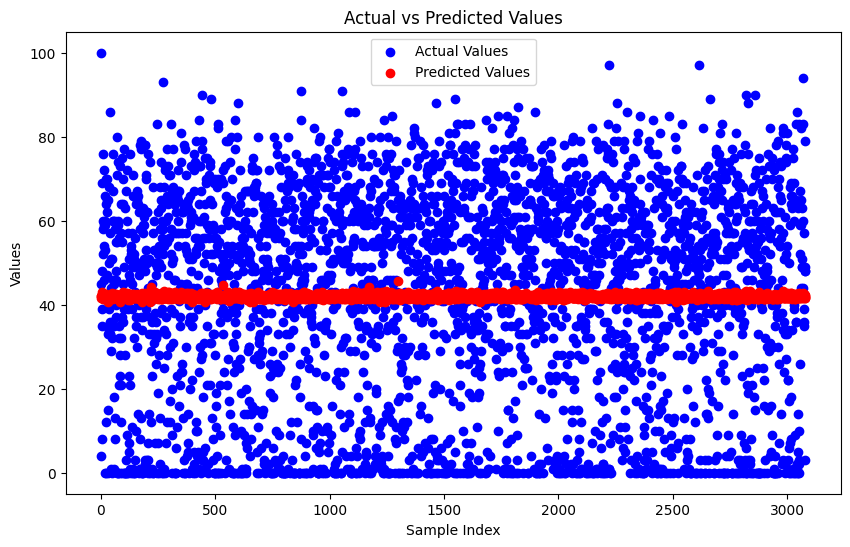

In [ ]:
# Plotting the actual vs predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Values')
plt.scatter(range(len(y_pred_test)), y_pred_test, color='red', label='Predicted Values')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()


In [ ]:
temp_df1 = pd.DataFrame()
temp_df1['actual'] = y_test
temp_df1['pred'] = y_pred_test


In [ ]:
temp_df1.to_csv('hh.csv')

# New Section